<a href="https://colab.research.google.com/github/hadijannat/hadijannat/blob/main/Identification_Praktikum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Heat Transfer in a Two-Compartment Metal Bar: Parameter Identification Praktikum


1.   Introduction

In this praktikum, we'll explore heat transfer modeling and parameter identification for a two-compartment metal bar. We'll simulate data, add realistic measurement errors, and then use this synthetic data to estimate key heat transfer parameters.


2.   Setup and Imports




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import least_squares

# Enable inline plotting
%matplotlib inline



3.   Model Parameters and Simulation

We'll start by defining our model parameters and creating a function to simulate the heat transfer process.

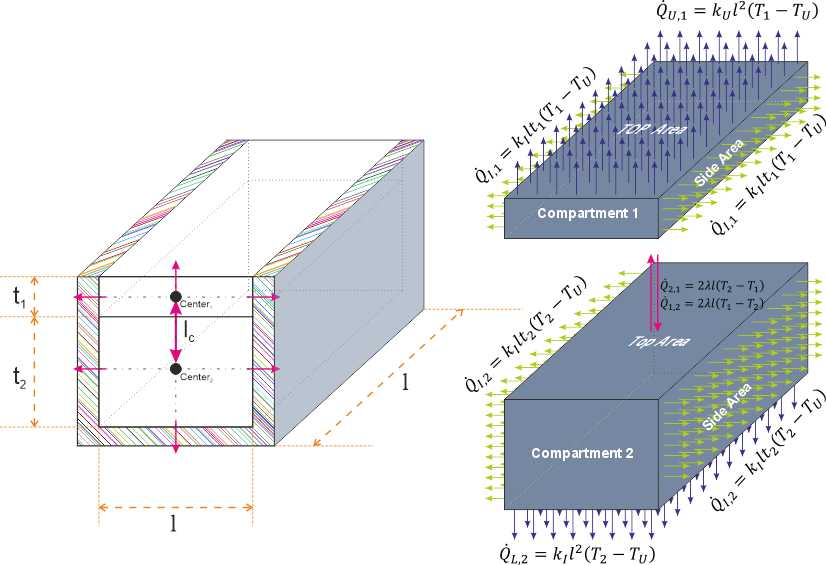





3.1. Physical System

The system consists of a metal bar with two compartments of different
thicknesses. The bar exchanges heat with the environment through its upper
surface and insulated sides.

3.2. Assumptions

To simplify our model, we make the following assumptions:
*  The temperature varies only across the cross-section of the bar (1D
model).
* Heat conduction within the metal bar follows Fourier’s law.
* Heat loss through the upper surface occurs via convection.
* Heat loss through the insulated sides occurs via a combination of
conduction and convection.
* The ambient temperature varies with time according to a predefined
function.

These assumptions allow us to create a manageable model while still
capturing the essential heat transfer dynamics.

3.3. Mathematical Model

Based on these assumptions, we derive the following heat transfer equations:

\begin{align}
\dot{Q}_{2,1} &= \frac{\lambda A(T_2 - T_1)}{l_c} = \frac{\lambda l^2(T_2 - T_1)}{l/2} = 2\lambda l(T_2 - T_1) \\
\dot{Q}_{1,2} &= \frac{\lambda A(T_1 - T_2)}{l_c} = \frac{\lambda l^2(T_1 - T_2)}{l/2} = 2\lambda l(T_1 - T_2) \\
\dot{Q}_{I,1} &= k_I A_{I1}(T_1 - T_U) = k_I lt_1(T_1 - T_U) \\
\dot{Q}_{I,2} &= k_I A_{I2}(T_2 - T_U) = k_I lt_2(T_2 - T_U) \\
\dot{Q}_{L,2} &= k_I A(T_2 - T_U) = k_I l^2(T_2 - T_U) \\
\dot{Q}_{U,1} &= k_U A(T_1 - T_U) = k_U l^2(T_1 - T_U)
\end{align}

Where:

* $\dot{Q}_{2,1}$ and $\dot{Q}_{1,2}$ represent the heat transfer between compartments 1 and 2
* $\dot{Q}_{I,1}$ and $\dot{Q}_{I,2}$ represent the heat transfer through the insulated sides of compartments 1 and 2
* $\dot{Q}_{L,2}$ represents the heat transfer through the lower surface of compartment 2
* $\dot{Q}_{U,1}$ represents the heat transfer through the upper surface of compartment 1
* $\lambda$ is the thermal conductivity of the metal bar
* $k_I$ is the heat transfer coefficient for the insulated sides
* $k_U$ is the heat transfer coefficient for the upper surface
* $l$ is the length of the bar
* $t_1$ and $t_2$ are the thicknesses of compartments 1 and 2
* $T_1$, $T_2$, and $T_U$ are the temperatures of compartment 1, compartment 2, and the ambient environment, respectively


Using these heat transfer equations, we can now formulate the differential equations describing the temperature change in each compartment:

\begin{align}
m_1c_p\frac{dT_1}{dt} &= \dot{Q}_{2,1} - 2\dot{Q}_{I,1} - \dot{Q}_{U,1} \\
&= 2\lambda l(T_2 - T_1) - 2k_I lt_1(T_1 - T_U) - k_U l^2(T_1 - T_U) \\
m_2c_p\frac{dT_2}{dt} &= \dot{Q}_{1,2} - 2\dot{Q}_{I,2} - \dot{Q}_{L,2} \\
&= 2\lambda l(T_1 - T_2) - 2k_I lt_2(T_2 - T_U) - k_I l^2(T_2 - T_U)
\end{align}

These equations describe the rate of temperature change in each compartment based on the heat transfer between compartments and with the environment.


4.   Model Description

The system can be described by the following state-space representation:


\begin{equation}
\frac{d}{dt}
\begin{bmatrix}
T_1 \\
T_2
\end{bmatrix}
= A
\begin{bmatrix}
T_1 \\
T_2
\end{bmatrix}
+ b T_U
\end{equation}

where the matrices $A$ and $B$ are defined as:

\begin{equation}
A = \begin{bmatrix}
\frac{-(2\lambda l + 2k_I lt_1 + k_U l^2)}{m_1 c_p} & \frac{2\lambda l}{m_1 c_p} \\
\frac{2\lambda l}{m_2 c_p} & \frac{-(2\lambda l + 2k_I lt_2 + k_I l^2)}{m_2 c_p}
\end{bmatrix}
\end{equation}

\begin{equation}
b = \begin{bmatrix}
\frac{(2k_I lt_1 + k_U l^2)}{m_1 c_p} \\
\frac{(2k_I lt_2 + k_I l^2)}{m_2 c_p}
\end{bmatrix}
\end{equation}

This state-space representation encapsulates the heat transfer dynamics of our two-compartment system:


* The matrix $A$ describes how the temperatures of the two compartments ($T_1$ and $T_2$) interact with each other and how they change over time.
* The vector $b$ represents how the ambient temperature ($T_U$) influences the temperatures of both compartments.
* The diagonal elements of $A$ represent the rate of heat loss from each compartment to the environment and to the other compartment.
* The off-diagonal elements of $A$ represent the heat transfer between the two compartments.
* The elements of $b$ show how changes in the ambient temperature affect each compartment, taking into account the surface areas and heat transfer coefficients.

This formulation allows us to solve the system of differential equations numerically and predict the temperature evolution in both compartments over time, given an initial temperature distribution and a known ambient temperature function $T_U(t)$.

In our simulation and parameter estimation processes, we will use this state-space model to generate synthetic data and to fit our model to the "measured" temperatures.




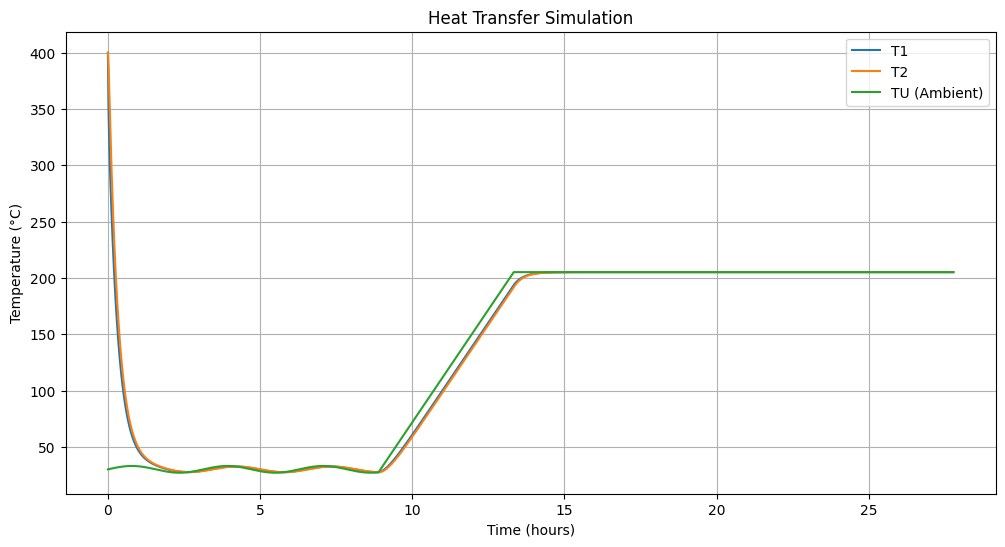

In [ ]:
# State parameters
m = 4  # Total mass [kg]
cp = 1.4  # Specific heat capacity [kJ/kg/K]
lmbd = 0.1  # Thermal conductivity [kW/m/K]
kU = 0.5  # Heat transfer coefficient for upper surface [kW/m^2/K]
kI = 0.01  # Heat transfer coefficient for insulated sides [kW/m^2/K]
l = 0.1  # Length of the bar [m]
t1 = 0.05  # Thickness of compartment 1 [m]
t2 = 0.1  # Thickness of compartment 2 [m]
U = 30  # Base temperature for TU function [°C]

# Derived parameters
m1 = m * t1 / (t1 + t2)
m2 = m * t2 / (t1 + t2)

# Ambient temperature function
def TU_func(t):
    if t < 32000:
        return (0.1 * np.sin(1/(60*30) * t) + 1) * U
    elif 32000 <= t < 48000:
        return ((0.1 * np.sin(1/(60*30) * 32000) + 1) * U +
                (t - 32000)/(60*30) * 20)
    else:
        return ((0.1 * np.sin(1/(60*30) * 32000) + 1) * U +
                16000/(60*30) * 20)

# Simulation function
def simulate(t, T0, TU_func, params):
    lmbd, kU, kI = params
    def dTdt(T, t):
        T1, T2 = T
        TU = TU_func(t)
        dT1dt = (1/(m1*cp)) * (2*lmbd*l*(T2-T1) - 2*kI*l*t1*(T1-TU) - kU*l**2*(T1-TU))
        dT2dt = (1/(m2*cp)) * (2*lmbd*l*(T1-T2) - 2*kI*l*t2*(T2-TU) - kI*l**2*(T2-TU))
        return [dT1dt, dT2dt]
    return odeint(dTdt, T0, t)

# Simulation
t = np.linspace(0, 100000, 3000)  # Extended simulation time
T0 = np.array([400, 400])  # Initial temperatures
params_true = [lmbd, kU, kI]
T = simulate(t, T0, TU_func, params_true)

# Plot the simulation results
plt.figure(figsize=(12, 6))
plt.plot(t/3600, T[:, 0], label='T1')
plt.plot(t/3600, T[:, 1], label='T2')
plt.plot(t/3600, [TU_func(ti) for ti in t], label='TU (Ambient)')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('Heat Transfer Simulation')
plt.grid(True)
plt.show()



5.   Adding Realistic Data Features


Now, we'll add realistic measurement features to our simulated data, including noise, drift, outliers, and data gaps.


  5.1.   Real Data Measurement Challenges



While our simulation provides valuable insights, real-world measurements
introduce additional complexities:
* **Sensor Noise**: Electronic noise in measurement devices introduces
random fluctuations.
* **Sensor Drift**: Gradual, systematic errors due to sensor calibration
changes over time.
* **Spikes**: Sudden, short-lived extreme values due to interference or
transient phenomena.
* **Outliers**: Occasional erroneous readings that significantly deviate from
true temperatures.
* **Environmental Factors**: Variations in ambient conditions introducing
unexpected patterns.
* **Sampling Rate Limitations**: Potentially missing rapid temperature
changes.
Figure below illustrates these challenges in a typical set of real temperature
measurements.
Understanding these real-world data challenges is crucial for developing
robust data preprocessing and parameter estimation methods.



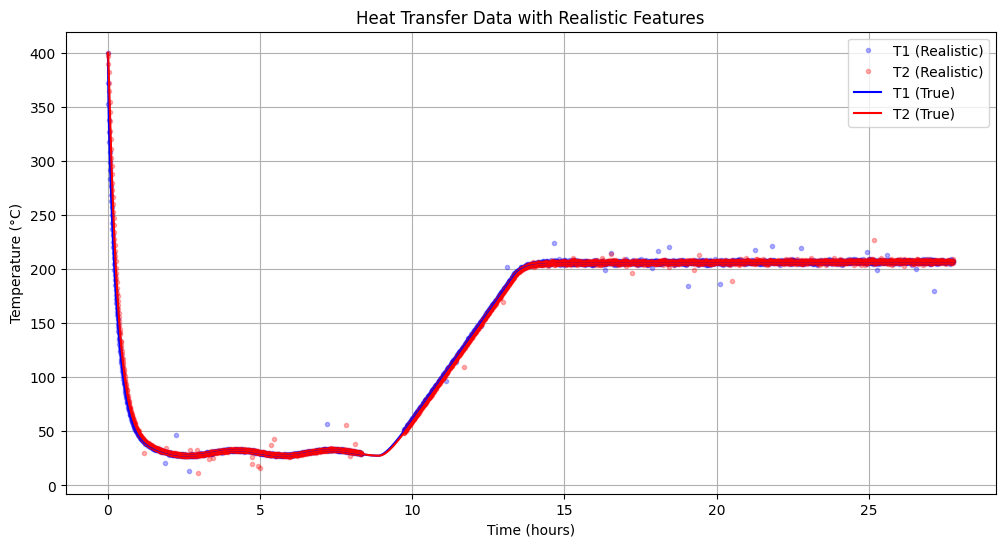

In [ ]:
def add_realistic_features(T, t):
    T_realistic = T.copy()

    # Add varying levels of noise
    noise_level = np.where(t < 50000, 0.5, 1.0)
    T_realistic += np.random.normal(0, noise_level[:, np.newaxis], T.shape)

    # Add drift
    drift = np.linspace(0, 2, len(t))[:, np.newaxis]
    T_realistic += drift

    # Add outliers
    outlier_mask = np.random.random(T.shape) < 0.01
    T_realistic[outlier_mask] += np.random.normal(0, 10, np.sum(outlier_mask))

    # Add gaps (NaN values)
    gap_mask = (t > 30000) & (t < 35000)
    T_realistic[gap_mask] = np.nan

    return T_realistic

T_realistic = add_realistic_features(T, t)

# Plot the realistic data
plt.figure(figsize=(12, 6))
plt.plot(t/3600, T_realistic[:, 0], 'b.', alpha=0.3, label='T1 (Realistic)')
plt.plot(t/3600, T_realistic[:, 1], 'r.', alpha=0.3, label='T2 (Realistic)')
plt.plot(t/3600, T[:, 0], 'b-', label='T1 (True)')
plt.plot(t/3600, T[:, 1], 'r-', label='T2 (True)')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('Heat Transfer Data with Realistic Features')
plt.grid(True)
plt.show()


6.   Data Cleaning and Preprocessing

Before we can use our data for parameter estimation, we need to clean and preprocess it. We'll remove outliers, interpolate gaps, and apply smoothing.

To prepare our data for parameter estimation, we apply the following steps:
* Outlier removal using Z-score method
* Gap interpolation using linear interpolation
* Smoothing using moving average filter
Figure below illustrates the effects of these preprocessing steps on our
temperature data


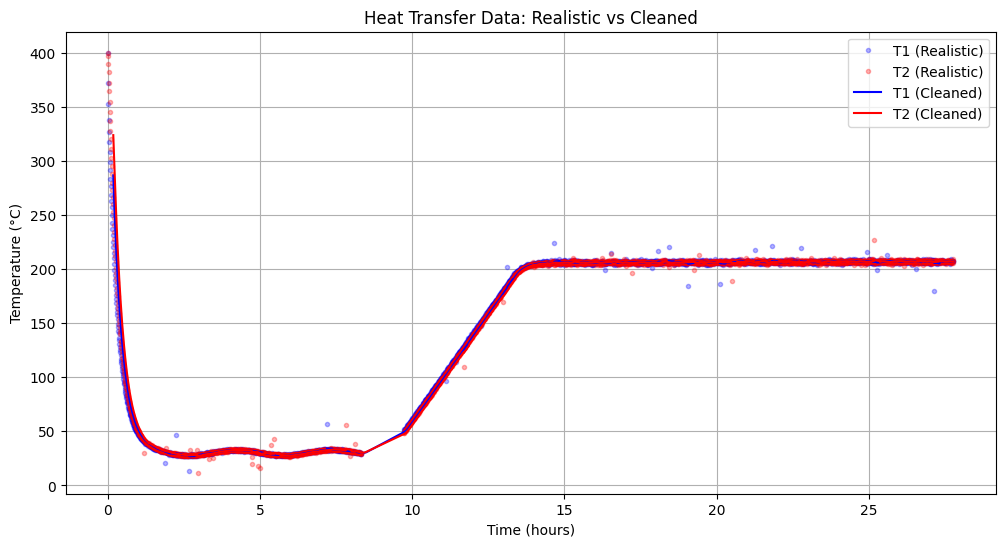

In [ ]:
def clean_data(T, t, window_size=20):
    T_clean = T.copy()

    # Remove outliers (simple Z-score method)
    z_scores = np.abs((T_clean - np.nanmean(T_clean, axis=0)) / np.nanstd(T_clean, axis=0))
    T_clean[z_scores > 3] = np.nan

    # Interpolate gaps
    for i in range(T_clean.shape[1]):
        mask = np.isnan(T_clean[:, i])
        T_clean[mask, i] = np.interp(t[mask], t[~mask], T_clean[~mask, i])

    # Moving average
    T_clean = np.apply_along_axis(lambda x: np.convolve(x, np.ones(window_size), 'valid') / window_size, 0, T_clean)
    t_clean = t[window_size-1:]

    return T_clean, t_clean

T_clean, t_clean = clean_data(T_realistic, t)

# Plot the cleaned data
plt.figure(figsize=(12, 6))
plt.plot(t/3600, T_realistic[:, 0], 'b.', alpha=0.3, label='T1 (Realistic)')
plt.plot(t/3600, T_realistic[:, 1], 'r.', alpha=0.3, label='T2 (Realistic)')
plt.plot(t_clean/3600, T_clean[:, 0], 'b-', label='T1 (Cleaned)')
plt.plot(t_clean/3600, T_clean[:, 1], 'r-', label='T2 (Cleaned)')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('Heat Transfer Data: Realistic vs Cleaned')
plt.grid(True)
plt.show()


7.   Parameter Estimation

Now that we have clean data, we can estimate the key parameters λ, kU, and kI using the least squares method.


* Define the residual function:

    $ r(\theta) = \sum_{i=1}^N (T_{measured,i} - T_{model,i}(\theta))^2 $, where $\theta = [k_U, k_I]$ are the parameters to be estimated.

* Minimize the residual function using an optimization algorithm (e.g., Levenberg-Marquardt).
* Obtain the estimated parameters $\hat{k}_U$ and $\hat{k}_I$ from the optimization result.



In [ ]:
import pandas as pd
from IPython.display import display

def model(params, t, T0, TU_func):
    return simulate(t, T0, TU_func, params)

def residuals(params, t, T_measured, T0, TU_func):
    T_model = model(params, t, T0, TU_func)
    return (T_model - T_measured).flatten()

# Perform identification
TU_clean = np.array([TU_func(ti) for ti in t_clean])
params_initial = [0.1, 0.1, 0.001]  # Initial guess for lmbd, kU, and kI
result = least_squares(residuals, params_initial, args=(t_clean, T_clean, T0, TU_func))

lmbd_identified, kU_identified, kI_identified = result.x

print(f"Original lmbd: {lmbd}, Identified lmbd: {lmbd_identified}")
print(f"Original kU: {kU}, Identified kU: {kU_identified}")
print(f"Original kI: {kI}, Identified kI: {kI_identified}")

# Create and display the table
data = {
    'Parameter': ['kU [kW m⁻² K⁻¹]', 'kI [kW m⁻² K⁻¹]'],
    'Original Value': [kU, kI],
    'Identified Value': [kU_identified, kI_identified]
}

df = pd.DataFrame(data)
df = df.set_index('Parameter')
df['Original Value'] = df['Original Value'].apply(lambda x: f"{x:.4f}")
df['Identified Value'] = df['Identified Value'].apply(lambda x: f"{x:.4f}")

print("\nTable 1: Original and Identified Parameter Values")
display(df)

Original lmbd: 0.1, Identified lmbd: 0.03936117796525562
Original kU: 0.5, Identified kU: 0.35194759394891634
Original kI: 0.01, Identified kI: 0.08008359380026013

Table 1: Original and Identified Parameter Values


,Original Value,Identified Value
Parameter,,
kU [kW m⁻² K⁻¹],0.5000,0.3519
kI [kW m⁻² K⁻¹],0.0100,0.0801


8.   Model Verification

Finally, we'll verify our estimated parameters by simulating the system with these parameters and comparing the results to our cleaned data.

To ensure our estimated parameters produce a valid model, we perform the
following verification steps:

* Simulate the system using the estimated parameters $\hat{k}_U$ and $\hat{k}_I$.
* Compare the simulated temperatures with the cleaned measure
* Compare the simulated temperatures with the cleaned measured data.
* Calculate error metrics such as Mean Squared Error (MSE) and R-squared value.
* Perform residual analysis to check for any remaining patterns or correlations.

Figure below illustrates the comparison between measured data and model
predictions.




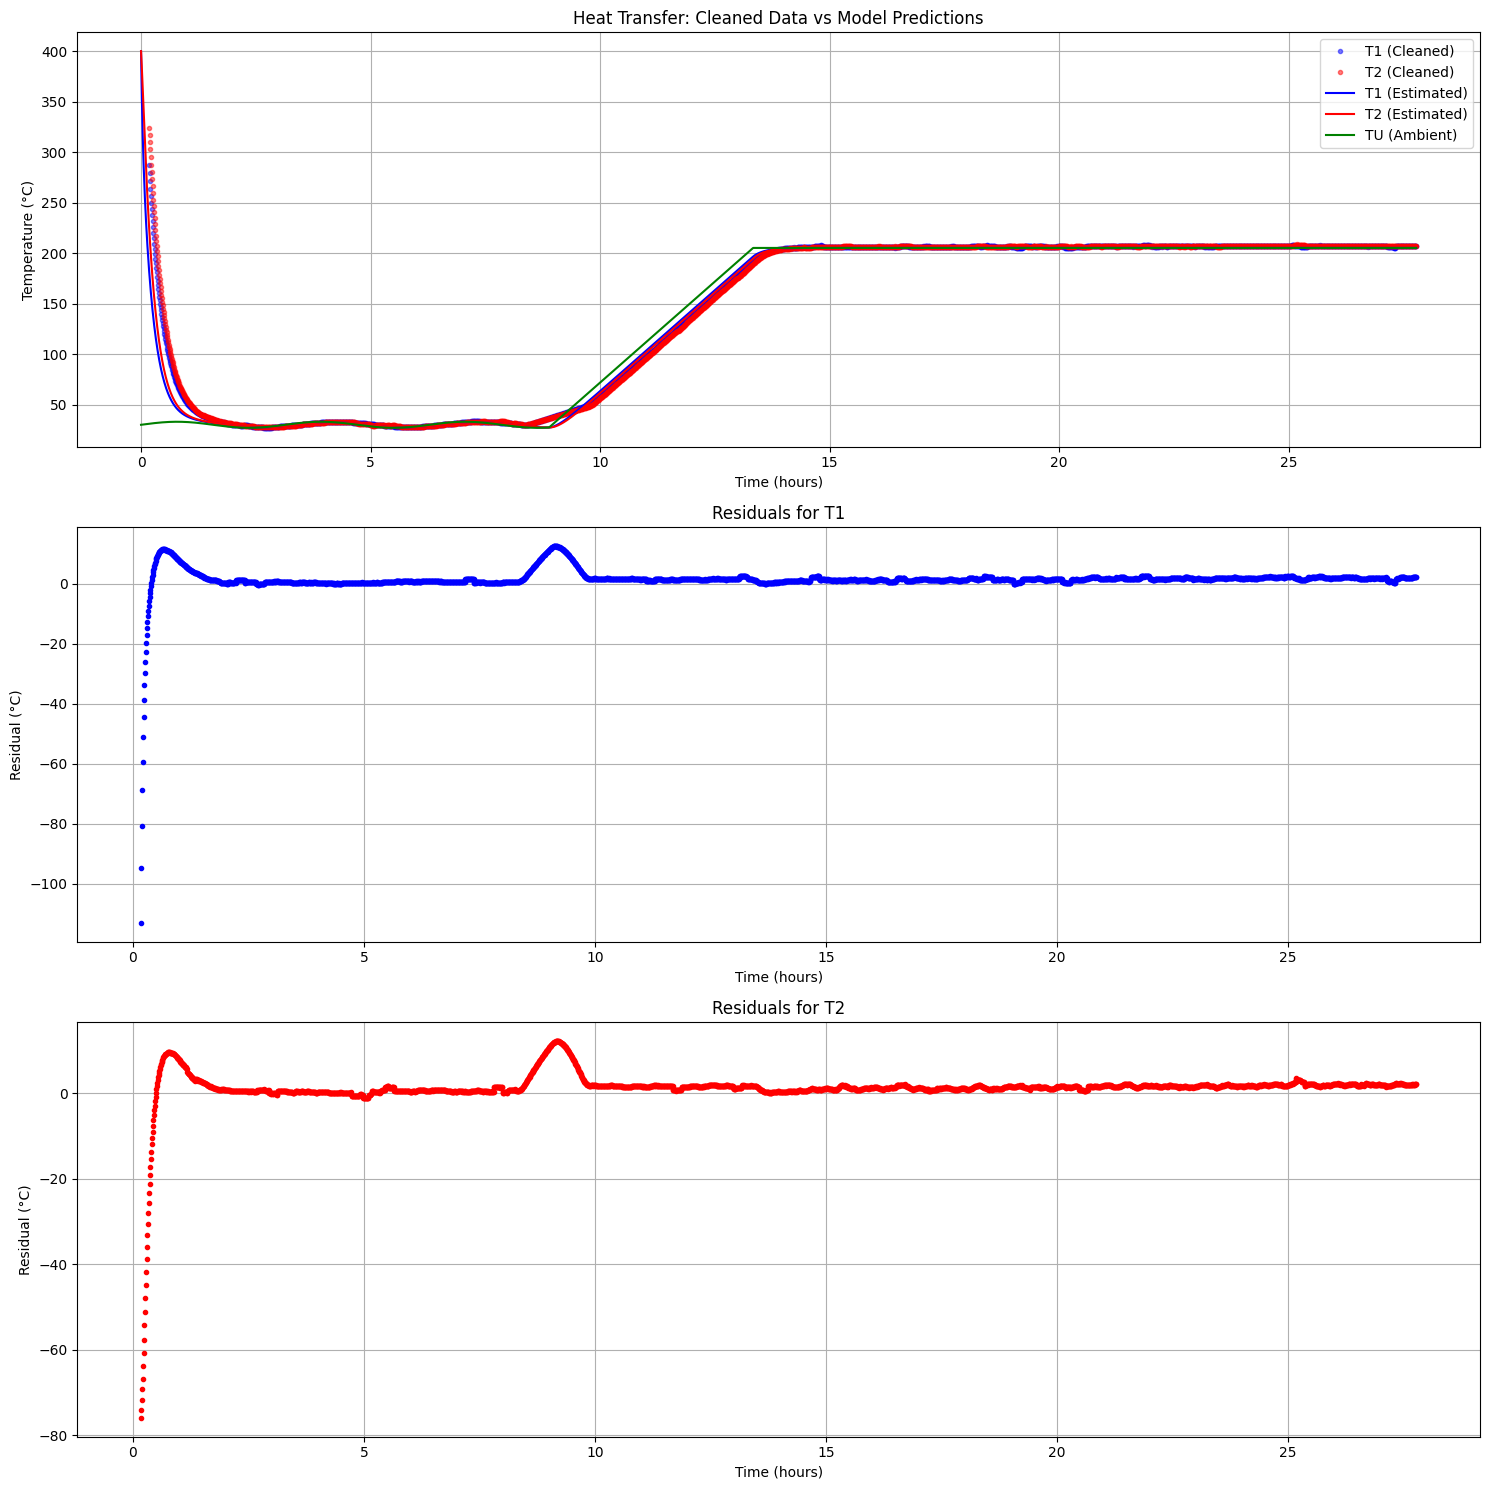

Mean Squared Error (T1): 23.4784
Mean Squared Error (T2): 25.9841
R-squared (T1): 0.9963
R-squared (T2): 0.9959


In [ ]:
# Generate estimated temperatures using identified parameters
T_estimated = simulate(t, T0, TU_func, [lmbd_identified, kU_identified, kI_identified])

# Calculate residuals
residuals_T1 = T_clean[:, 0] - T_estimated[:len(T_clean), 0]
residuals_T2 = T_clean[:, 1] - T_estimated[:len(T_clean), 1]

# Plotting
plt.figure(figsize=(15, 15))

# Temperature plots
plt.subplot(3, 1, 1)
plt.plot(t_clean/3600, T_clean[:, 0], 'b.', alpha=0.5, label='T1 (Cleaned)')
plt.plot(t_clean/3600, T_clean[:, 1], 'r.', alpha=0.5, label='T2 (Cleaned)')
plt.plot(t/3600, T_estimated[:, 0], 'b-', label='T1 (Estimated)')
plt.plot(t/3600, T_estimated[:, 1], 'r-', label='T2 (Estimated)')
plt.plot(t/3600, [TU_func(ti) for ti in t], 'g-', label='TU (Ambient)')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.title('Heat Transfer: Cleaned Data vs Model Predictions')
plt.grid(True)

# Residuals for T1
plt.subplot(3, 1, 2)
plt.plot(t_clean/3600, residuals_T1, 'b.')
plt.title('Residuals for T1')
plt.xlabel('Time (hours)')
plt.ylabel('Residual (°C)')
plt.grid(True)

# Residuals for T2
plt.subplot(3, 1, 3)
plt.plot(t_clean/3600, residuals_T2, 'r.')
plt.title('Residuals for T2')
plt.xlabel('Time (hours)')
plt.ylabel('Residual (°C)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate error metrics
mse_T1 = np.mean(residuals_T1**2)
mse_T2 = np.mean(residuals_T2**2)
r2_T1 = 1 - np.sum(residuals_T1**2) / np.sum((T_clean[:, 0] - np.mean(T_clean[:, 0]))**2)
r2_T2 = 1 - np.sum(residuals_T2**2) / np.sum((T_clean[:, 1] - np.mean(T_clean[:, 1]))**2)

print(f"Mean Squared Error (T1): {mse_T1:.4f}")
print(f"Mean Squared Error (T2): {mse_T2:.4f}")
print(f"R-squared (T1): {r2_T1:.4f}")
print(f"R-squared (T2): {r2_T2:.4f}")



9.   Conclusion and Discussion

In this praktikum, we've gone through the process of simulating heat transfer data, adding realistic measurement features, cleaning the data, and using it to estimate key heat transfer parameters.
Key points to consider:

* How close are the estimated parameters to the true values?
* How well does the model with estimated parameters fit the cleaned data?
* What might be causing any discrepancies between the true and estimated parameters?
* How effective were our data cleaning methods?
* What improvements could be made to this process?
